# Time Series Forecasting - Stocks

In [1]:
## import required packages
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver
import os
import time

# --------------------------------------------------------------------------------------------------------------

In [2]:
# access Chrome driver
driver = webdriver.Chrome(r'C:\chromedriver_win32\chromedriver.exe')

company = input("enter the company's nasdaq stock exchange symbol: ")  ## specify the company abbreviation as on the NYSE

# go to stock data
url = "https://www.nasdaq.com/symbol/" + company.lower() + "/interactive-chart"
driver.get(url)
driver.implicitly_wait(12)
driver.switch_to.frame(driver.find_element_by_xpath('//*[@id="chartholder"]/iframe'))

# check if file exists
path = r'C:\Users\tereo\Downloads\grid.xls'
if os.path.isfile(path):
    os.remove(path)

# find and click on button
driver.find_element_by_xpath('//*[@id="dataTableBtn"]').click()
driver.find_element_by_xpath('//*[@id="gridContainer"]/div[1]/span[1]').click()

driver.close()

enter the company's nasdaq stock exchange symbol: aapl


# --------------------------------------------------------------------------------------------------------------

In [3]:
## load data via csv file (downloaded from nasdaq.com)
time.sleep(5)
data = pd.read_excel(r'C:\Users\tereo\Downloads\grid.xls')

## viewing data
print(data.head(5))
print(data.tail(5))

         Date    Open    High      Low   Close      Volume
0  2018-05-04  178.25  184.25  178.170  183.83  56137230.0
1  2018-05-07  185.18  187.67  184.750  185.16  42557530.0
2  2018-05-08  184.99  186.22  183.665  186.05  28053230.0
3  2018-05-09  186.55  187.40  185.220  187.36  23141260.0
4  2018-05-10  187.74  190.37  187.650  190.04  27942430.0
                                                  Date    Open    High  \
247                                         2019-04-30  203.06  203.40   
248                                         2019-05-01  200.67  215.31   
249                                         2019-05-02  210.52  212.65   
250                                         2019-05-03  210.89  211.46   
251  This document was made with Webix library. htt...     NaN     NaN   

        Low     Close      Volume  
247  199.11  200.6700  45751160.0  
248  209.23  210.5200  64827330.0  
249  208.13  209.1500  31996320.0  
250  210.32  210.9305   2038280.0  
251     NaN       NaN

In [4]:
## removing unwanted row
data = data[:(len(data)-1)]

## data summary
data.describe()

Open        High         Low       Close        Volume
count  251.000000  251.000000  251.000000  251.000000  2.510000e+02
mean   191.318797  193.216447  189.511482  191.436616  3.152717e+07
std     21.322216   21.513225   21.238181   21.346390  1.425071e+07
min    143.980000  145.720000  142.000000  142.190000  2.038280e+06
25%    174.805000  175.935000  173.945000  174.920000  2.192838e+07
50%    190.020000  191.680000  188.540000  190.290000  2.773858e+07
75%    207.850000  210.090000  206.905000  208.875000  3.763308e+07
max    230.780000  233.470000  229.780000  232.070000  9.558408e+07

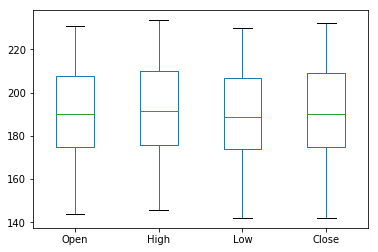

In [5]:
data.plot(y=['Open', 'High', 'Low','Close'], kind = 'box')

C:\Users\tereo\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


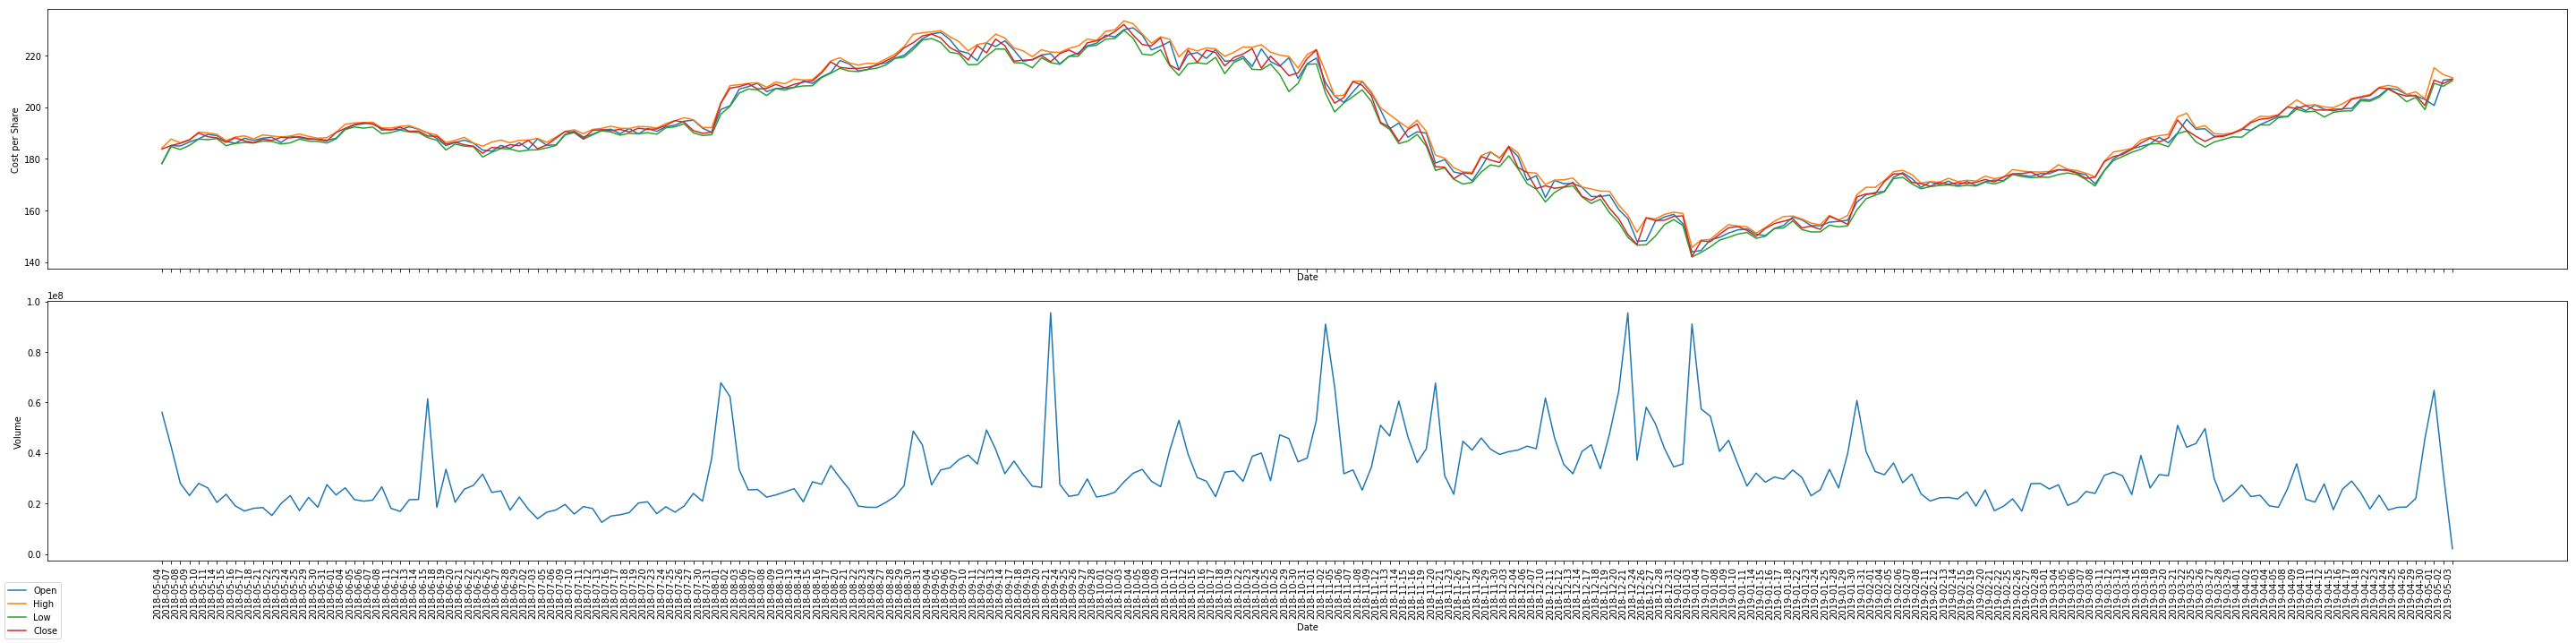

In [6]:
## plotting data - checking for stationarity
fig = plt.figure(figsize = (40, 10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

l1, l2, l3, l4 = ax1.plot(data['Date'], data['Open'], 
                          data['Date'], data['High'], 
                          data['Date'], data['Low'], 
                          data['Date'], data['Close'])
ax2.plot(data['Date'], data['Volume'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate() 

# use a more precise date string for the x axis locations in the toolbar
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax1.set_xlabel('Date')
ax1.set_ylabel('Cost per Share')

ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')

plt.setp(ax1.get_xticklabels(), rotation='vertical', fontsize=10)
plt.setp(ax2.get_xticklabels(), rotation='vertical', fontsize=10)

fig.legend((l1, l2, l3, l4), ('Open', 'High', 'Low', 'Close'), 'lower left')
fig.tight_layout()
fig.savefig('UPS Stock.png')
fig.show()

# --------------------------------------------------------------------------------------------------------------

## MA, AR, and ARMA times series

In [7]:
# MA example
from statsmodels.tsa.arima_model import ARMA

# fit model
UPS_MA = ARMA(data['Close'], order=(1, 1, 1))
UPS_MA_fit = UPS_MA.fit(disp=False)

# make prediction
yhat_MA = UPS_MA_fit.predict(len(data), len(data))
print(yhat_MA)

251    210.625895
dtype: float64


In [8]:
# AR example
from statsmodels.tsa.ar_model import AR

# fit model
UPS_AR = AR(data['Close'])
UPS_AR_fit = UPS_AR.fit()

# make prediction
yhat_AR = UPS_AR_fit.predict(len(data), len(data))
print(yhat_AR)

251    210.400899
dtype: float64


In [9]:
# ARMA
from statsmodels.tsa.arima_model import ARMA

# fit model
UPS_ARMA = ARMA(data['Close'], order=(2, 1))
UPS_ARMA_fit = UPS_ARMA.fit(disp=False)

# make prediction
yhat_ARMA = UPS_ARMA_fit.predict(len(data), len(data))
print(yhat_ARMA)

251    210.53069
dtype: float64


# --------------------------------------------------------------------------------------------------------------

## ARIMA

In [10]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

steps = 20

stock_points = ['Open', 'High', 'Low', 'Close', 'Volume']
adfs = []
p_vals = []
cvs = []
keys = []

for point in stock_points:
    X = data[point]
    result = adfuller(X)
    adfs.append(result[0])
    p_vals.append(result[1])
    cv = []
    key_ = []
    for key, value in result[4].items():
        key_.append(key)
        cv.append(value)
    keys.append(key_)
    cvs.append(cv)
    
df_adf = pd.DataFrame([adfs, p_vals, cvs, keys], columns = stock_points)
df_adf

Open  \
0                                           -1.47335   
1                                            0.54665   
2  [-3.4578942529658563, -2.8736593200231484, -2....   
3                                      [1%, 5%, 10%]   

                                                High  \
0                                           -1.05107   
1                                           0.734185   
2  [-3.4568881317725864, -2.8732185133016057, -2....   
3                                      [1%, 5%, 10%]   

                                                 Low  \
0                                          -0.952001   
1                                           0.770366   
2  [-3.4569962781990573, -2.8732659015936024, -2....   
3                                      [1%, 5%, 10%]   

                                               Close  \
0                                           -1.13868   
1                                           0.699402   
2  [-3.456780859712, -2.8731715065600003, -2.5729...   
3                                      [1%, 5%, 10%]   

                                              Volume  
0                                           -2.94646  
1                                          0.0402065  
2  [-3.457437824930831, -2.873459364726563, -2.57...  
3                                      [1%, 5%, 10%]

In [11]:
# open
Open = ARIMA(data['Open'], order=(2, 1, 1))
Open_fit = Open.fit(disp=False)
Open_frcst = Open_fit.forecast(steps=steps, exog=None, alpha=0.05)

# high
High = ARIMA(data['High'], order=(2, 1, 1))
High_fit = High.fit(disp=False)
High_frcst = High_fit.forecast(steps=steps, exog=None, alpha=0.05)

# low
Low = ARIMA(data['Low'], order=(2, 1, 1))
Low_fit = Low.fit(disp=False)
Low_frcst = Low_fit.forecast(steps=steps, exog=None, alpha=0.05)

# close
Close = ARIMA(data['Close'], order=(2, 1, 1))
Close_fit = Close.fit(disp=False)
Close_frcst = Close_fit.forecast(steps=steps, exog=None, alpha=0.05)

# volume
Volume = ARIMA(data['Volume'], order=(1, 1, 1))
Volume_fit = Volume.fit(disp=False)
Vol_frcst = Volume_fit.forecast(steps=steps, exog=None, alpha=0.05)

In [12]:
## forecasting

of = list(Open_frcst)
hf = list(High_frcst)
lf = list(Low_frcst)
cf = list(Close_frcst)
vf = list(Vol_frcst)

df_of = pd.DataFrame(of)
df_of = df_of.rename(index = {0:'Open', 1:'Open stderr', 2:'Open CI'})

df_hf = pd.DataFrame(hf)
df_hf = df_hf.rename(index = {0:'High', 1:'High stderr', 2:'High CI'})

df_lf = pd.DataFrame(lf)
df_lf = df_lf.rename(index = {0:'Low', 1:'Low stderr', 2:'Low CI'})

df_cf = pd.DataFrame(cf)
df_cf = df_cf.rename(index = {0:'Close', 1:'Close stderr', 2:'Close CI'})

df_vf = pd.DataFrame(vf)
df_vf = df_vf.rename(index = {0:'Volume', 1:'Volume stderr', 2:'Volume CI'})

results = [df_of, df_hf, df_lf, df_cf, df_vf]
df_results = pd.concat(results)
df_results = df_results.transpose()

samples = []
for i in range(steps):
    samples.append(i)

df_results['Forecasted Data Points'] = samples

df_results.head()

Open Open stderr                                   Open CI     High  \
0  211.141     3.27694  [204.71801422562572, 217.56337038031506]  211.427   
1  211.266     4.52233     [202.4023697362883, 220.129572459115]   211.63   
2  211.398     5.52207   [200.5748505356027, 222.22095220334398]  211.788   
3  211.528       6.364   [199.05459606544903, 224.0009982864008]  211.904   
4  211.658     7.10733  [197.72780181838388, 225.58801917358002]  212.011   

  High stderr                                   High CI      Low Low stderr  \
0     2.83992   [205.8605520034005, 216.99283488287497]   210.61    2.95736   
1     4.28505  [203.23119852008978, 220.02830034018604]  210.463    4.52232   
2     5.24493   [201.5078737777377, 222.06760718160774]  210.439    5.50158   
3     6.00278  [200.13875228364904, 223.66921429106688]  210.544     6.2304   
4     6.66805   [198.9415078415077, 225.07977426893962]  210.687    6.86301   

                                     Low CI    Close Close stderr  \
0  [204.81345204618225, 216.40607537574573]  210.837      3.43479   
1  [201.59952224876758, 219.32671047636745]  210.768      4.76052   
2   [199.65611629371625, 221.2219099870992]  210.826      5.64401   
3  [198.33268327571977, 222.75540326997236]  210.925      6.36795   
4  [197.23570067527172, 224.13820483492796]  211.032      7.01251   

                                   Close CI       Volume Volume stderr  \
0   [204.1053331863286, 217.56944552815787]  1.54682e+07   1.16983e+07   
1  [201.43797380550518, 220.09886758790583]  2.02055e+07   1.29292e+07   
2   [199.7637220150583, 221.88781828580233]  2.17873e+07   1.33334e+07   
3   [198.44446853727007, 223.4063813256101]  2.22236e+07   1.35551e+07   
4  [197.28753586613828, 224.77607529626295]  2.22442e+07   1.37239e+07   

                                  Volume CI  Forecasted Data Points  
0    [-7460152.02771396, 38396531.55375877]                       0  
1   [-5135376.521174174, 45546299.55520181]                       1  
2    [-4345667.459048003, 47920204.1065478]                       2  
3  [-4343944.216774002, 48791199.809634276]                       3  
4  [-4654166.763384368, 49142536.693709284]                       4

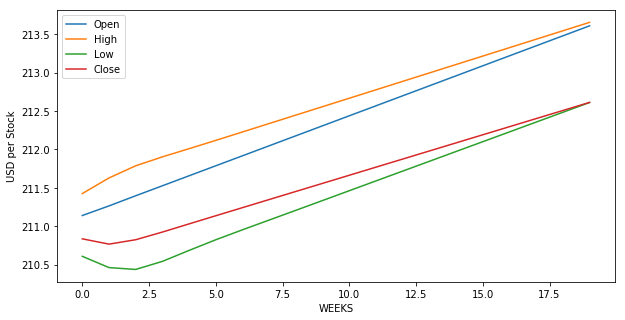

In [13]:
figure = plt.figure(figsize = (10, 5))
ax = plt.subplot()

l1, = ax.plot(df_results['Forecasted Data Points'], df_results['Open'], label = 'Open')
l2, = ax.plot(df_results['Forecasted Data Points'], df_results['High'], label = 'High') 
l3, = ax.plot(df_results['Forecasted Data Points'], df_results['Low'], label = 'Low') 
l4, = ax.plot(df_results['Forecasted Data Points'], df_results['Close'], label= 'Close')

ax.set_xlabel('WEEKS')
ax.set_ylabel('USD per Stock')
ax.legend()

fig.tight_layout()

# --------------------------------------------------------------------------------------------------------------

In [14]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model
UPS_SES = SimpleExpSmoothing(data['Close'])
UPS_SES_fit = UPS_SES.fit()

# make prediction
yhat_SES = UPS_SES_fit.predict(len(data), len(data))
print(yhat_SES)

251    210.861773
dtype: float64
